<a href="https://colab.research.google.com/github/sefrancogo/Analitica-de-Datos/blob/master/Covid_Paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget 
import pandas as pd
import numpy as np 
import wget 
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#path = 'data/Casos_positivos_de_COVID-19_en_Colombia04_15_2020.csv'

wget.download(url, 'datos_covid_paises.cvs')
data = pd.read_csv('datos_covid_paises.cvs')
data

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e4ecf1adbe3489ffc87934f00933aa991982adcd3a842949693c2995fbef3ea0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,6,6,34
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8


In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:        
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
        pi += 1
        pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

In [0]:
#Ubicar Posicion de pais
ii = data[data.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(data.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))

X, y = covid_win(serie,w=5)
X_d, y_d = covid_win(serie_d,w=5)

In [4]:
X[-1,:]

array([4356, 4561, 4881, 5142, 5379], dtype=object)

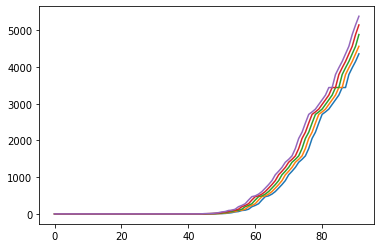

In [5]:
plt.plot(X)

### Analisis Exploratorio PCA

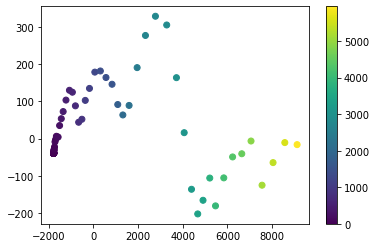

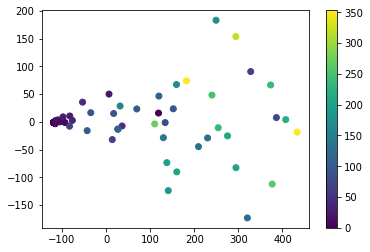

In [6]:
from sklearn.decomposition import PCA

red = PCA()
red_d = PCA()

z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Analisis Exploratorio TSNE

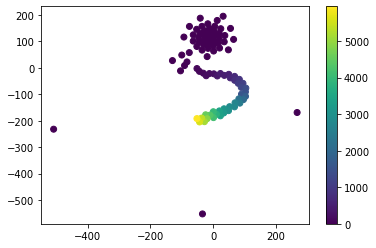

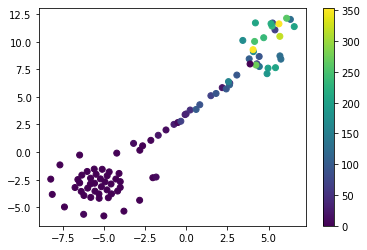

In [7]:
from sklearn.manifold import TSNE

red = TSNE(n_components = 2, perplexity=10)
red_d = TSNE(n_components = 2, perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Extrer conjunto de Entrenamiento y Prueba
Cuando se tienen pocos datos es necesario realizar una validaación cruzada anidada.

### Función Validación Cruzada Anidada


In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from joblib import dump, load

def V_Cruzada_Anidada(X_data,Y_data,steps,parameters):
  
  Niter = 10                           #numero particiones outter loop nested cross-validation
  msev = np.zeros((Niter,len(steps)))  #arreglo para guardar acierto
  best_estimators = []                 #mejor metodo por iteracion
  ###clave del funcionamiento
  best_hyperpar = []                   #mejor metodo por iteracion 
            

  for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size=0.3) # xtrain 60, xtest 26

      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          
          #guardar mejor modelo
          best_estimators.append(grid_search.best_estimator_)
          best_hyperpar.append(grid_search.best_params_)

          #guardar acierto
          msev[j,r] = mse(y_test,y_pred)
          #print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          #print(best_hyperpar)
          #print('mse:',msev[j,r])

          savedata = {
            'acc':msev,
            'best_models':best_estimators,
            'best_parameters':best_hyperpar,
              } 
          #dump(savedata,'covid19_1.joblib')

  return best_estimators,best_hyperpar,msev

### Validacion Cruzada Anidada LR:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRegression



In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  LinearRegression())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  LinearRegression())]
          ]

parameters = [
                {
                 },
                {
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_LR = ['NorSC-LR','NorSC-PCA-LR']

B_Model_LR, B_Hiperpara_LR, MAE_LR = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 2/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 3/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0061s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0080s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Us

Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 4/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 5/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0106s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0060s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Para

it 6/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 7/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 8/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0069s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0069s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0126s.) Setting batch_size=2.
[Pa

it 9/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 10/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elaps

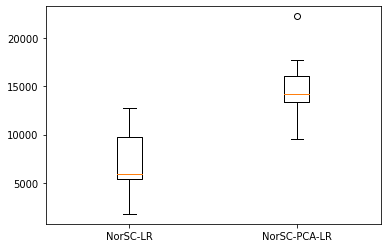

In [41]:
plt.boxplot(MAE_LR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_LR)
plt.show()

In [42]:
MAE_LR

array([[ 1754.49288999, 17719.72364233],
       [ 5899.05994451, 14434.57256053],
       [10571.7191216 , 13487.06517797],
       [10610.37453843, 16309.20877797],
       [12800.17065286, 22291.10321292],
       [ 5214.50451534, 11416.16663792],
       [ 5827.77476622,  9558.92988154],
       [ 5837.15466317, 15483.10432276],
       [ 7226.52680586, 13309.08677726],
       [ 4002.14214128, 14035.96823166]])

In [43]:
B_Hiperpara_LR

[{},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5}]

In [96]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', LinearRegression())]

Mod_SC_LR = Pipeline(steps = steps)
Mod_SC_LR.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [97]:
from datetime import date
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_LR = Mod_SC_LR.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)

Número de contagiados en los últimos 5 días: [[4356 4561 4881 5142 5379]]
Predicción contagios para 2020-04-29 usando un modelo LinearRegression: [[5922.24933583]]


### Validacion Cruzada Anidada Ridge:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRidge


In [105]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Ridge( ))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Ridge())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 },
                {'rep__n_components':[0.5,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 }
               ]

label_model_R = ['NorSC-R','NorSC-PCA-R']

B_Model_R, B_Hiperpara_R, MAE_R = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0497s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0910s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0100s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Don

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0987s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1047s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 2/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0684s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0888s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks   

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0688s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1249s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0074s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0390s.)

it 3/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0379s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0749s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1169s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0102s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0333s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 4/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0329s.) Setting batch_size=8.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 183 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 191 out of 200 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0102s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0400s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 5/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0827s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0064s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0064s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0368s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1952s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 106 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 157 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 191 out of 200 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0050s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0050s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)

it 6/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0916s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  58 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  91 out of 100 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0199s.) Setting batch_size=2.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0316s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0900s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1538s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.)

it 7/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0970s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=2.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0499s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1077s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0884s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0074s.)

it 8/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0620s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0542s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0341s.) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0849s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0973s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0099s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0330s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 9/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0374s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0656s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1356s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0220s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0267s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 10/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0445s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0693s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1077s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


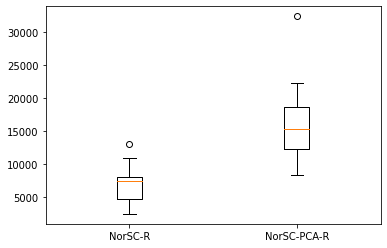

In [106]:
plt.boxplot(MAE_R)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_R)
plt.show()

In [107]:
MAE_R

array([[ 7869.25313468, 13142.82295287],
       [13023.81732653, 32346.92738142],
       [ 4264.90067217, 18216.44443231],
       [ 4113.06823881, 11509.34323687],
       [ 2432.19173278, 12133.38544875],
       [ 7591.03568374, 18815.16889478],
       [10968.97831974, 22216.69093769],
       [ 7314.72760079, 12502.67867209],
       [ 8076.5476007 ,  8263.28146432],
       [ 6076.14082531, 17501.63307805]])

In [108]:
B_Hiperpara_R

[{'reg__alpha': 0.001, 'reg__solver': 'sag'},
 {'reg__alpha': 0.1, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'sag', 'rep__n_components': 0.5},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 1, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.01, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.01, 'reg__solver': 'cholesky'},
 {'reg__alpha': 0.01, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__a

In [109]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.001, solver='lsqr'))]

Mod_SC_R = Pipeline(steps = steps)
Mod_SC_R.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='lsqr', tol=0.001))],
         verbose=False)

In [110]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_R = Mod_SC_R.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)

Número de contagiados en los últimos 5 días: [[4356 4561 4881 5142 5379]]
Predicción contagios para 2020-04-30 usando un modelo LinearRidge: [[5919.58309838]]


### Validacion Cruzada Anidada Lasso:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearLasso

In [111]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Lasso())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Lasso())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 },
                {'rep__n_components':[0.5,0.75,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 }
               ]

label_model_L = ['NorSC-L','NorSC-PCA-L']

B_Model_L, B_Hiperpara_L, MAE_L = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123528.54539464679, tolerance: 12301.78884375
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0056s.) Setting batch_si

it 2/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0411s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0508s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0078s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s rem

it 3/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0634s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

it 4/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0398s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0959s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s r

it 5/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0533s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

it 6/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0509s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0805s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 7/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117722.9722153871, tolerance: 10485.9324
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0069s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0069s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_j

it 8/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0157s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

it 9/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0330s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0610s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 10/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159478.7621305909, tolerance: 18440.3946484375
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parall

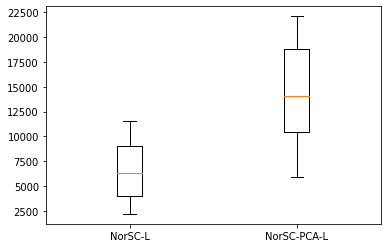

In [112]:
plt.boxplot(MAE_L)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_L)
plt.show()

In [113]:
MAE_L

array([[11161.06604627, 19482.21792534],
       [ 6640.97525282,  5919.86869916],
       [11513.49622599, 16055.44431423],
       [ 3109.23851501, 10212.59714304],
       [ 3686.01967329, 17355.47323804],
       [ 9136.07020486, 12085.83311715],
       [ 5944.91067366, 19312.95964885],
       [ 5117.14737798, 22076.80527041],
       [ 2223.46286298,  9209.95145389],
       [ 8722.41334879, 11120.86773453]])

In [114]:
B_Hiperpara_L

[{'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 1},
 {'reg__alpha': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5}]

In [115]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.1))]

Mod_SC_L = Pipeline(steps = steps)
Mod_SC_L.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [116]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_L = Mod_SC_L.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)

Número de contagiados en los últimos 5 días: [[4356 4561 4881 5142 5379]]
Predicción contagios para 2020-04-30 usando un modelo LinearLasso: [[5963.91703344]]


### Validacion Cruzada Anidada EN:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearElasticNet

In [120]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  ElasticNet())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  ElasticNet( ))]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100]
                 },
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100],
                  'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_EN = ['NorSC-EN','NorSC-PCA-EN']

B_Model_EN, B_Hiperpara_EN, MAE_EN = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1948s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done  32 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0266s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0733s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0691s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 198 tasks      | ela

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1322s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1579s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1885s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 596 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 611 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished


it 2/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0497s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0676s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1173s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0426s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0647s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1804s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.)

it 3/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1984s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 217 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 231 out of 240 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177774.79691243244, tolerance: 16456.43159375
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too f

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0770s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1241s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0158s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0436s.)

it 4/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0609s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1444s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1764s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219871.2734070139, tolerance: 17772.9821109375
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0383s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0828s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0926s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1992s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 508 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 596 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.1s

it 5/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0546s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0472s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1216s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1603s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_desce

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0343s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1171s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0924s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1923s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 552 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 596 tasks   

it 6/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0101s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0486s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1031s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0973s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1290s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1241s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0685s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1037s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1645s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 198 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 438 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 573 tasks   

it 7/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0380s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1097s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0761s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1096s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165056.07589882606, tolerance: 16949.45854375
  positive)
[Parallel(n_jobs=5)]: Using backend

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0377s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0668s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1394s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 680 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks  

it 8/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1123s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1795s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172943.66627913574, tolerance: 16368.589100000001
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0386s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0634s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1366s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1914s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 627 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 673 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.3s

it 9/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0588s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240722.9643873499, tolerance: 20773.6393359375
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0693s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1060s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 643 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 656 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 10/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0410s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0739s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1348s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1208s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0843s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1680s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 214 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 543 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 618 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 662 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 677 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 692 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 709 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]

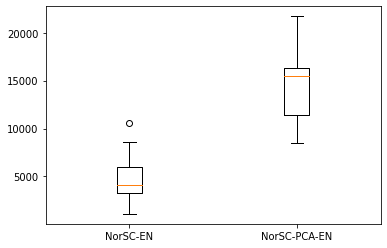

In [121]:
plt.boxplot(MAE_EN)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_EN)
plt.show()

In [122]:
MAE_EN

array([[ 8557.73316401, 21720.50660049],
       [ 6377.54284831, 13193.32161153],
       [10558.94378721, 15548.33492039],
       [ 3760.80488681, 15561.36948795],
       [ 3193.80574486, 20227.61476167],
       [ 1084.94191432,  8492.20839771],
       [ 4545.27509717, 15397.71750183],
       [ 4917.92729561, 16519.91598601],
       [ 1390.4924463 ,  9617.17150587],
       [ 3627.18281028, 10766.69147666]])

In [127]:
B_Hiperpara_EN

[{'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio'

In [129]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', ElasticNet(alpha=0.001, l1_ratio=1))]

Mod_SC_EN = Pipeline(steps = steps)
Mod_SC_EN.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160547.1853798428, tolerance: 17594.5919484375
  positive)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=1, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [130]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_EN = Mod_SC_EN.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)

Número de contagiados en los últimos 5 días: [[4356 4561 4881 5142 5379]]
Predicción contagios para 2020-04-30 usando un modelo LinearElasticNet: [5977.70391599]


### Validacion Cruzada Anidada KR:

- Normalización StandadScalar
- Representación PCA
- Regresor KernelRidge

In [131]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  KernelRidge(kernel = 'rbf'))]
          ]

parameters = [
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
                 },
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_KR = ['NorSC-KRRBF','NorSC-PCA-KRRBF']

B_Model_KR, B_Hiperpara_KR, MAE_KR = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0222s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0424s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0704s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1018s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Do

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1019s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1192s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 457 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0092s.) Setting batch_size=2

it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0865s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0897s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0133s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0133s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0507s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1219s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0059s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0059s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computatio

it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1505s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 171 out of 180 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0748s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1298s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0254s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0406s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0507s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0652s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 145 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 254 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 508 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0128s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0527s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0719s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0812s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0863s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0761s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0773s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0763s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 134 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0719s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1576s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1998s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 323 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 396 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 407 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 482 tasks   

it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0534s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 132 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0106s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0106s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0479s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1537s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1606s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 428 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 496 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 511 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 526 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n

it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0100s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0477s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1075s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  92 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 270 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 358 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 462 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 503 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[

it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0637s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 165 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0470s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1154s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 146 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 290 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 466 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0343s.) Setting batch_size=4.


it 10/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0726s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1367s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0765s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0758s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1496s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished


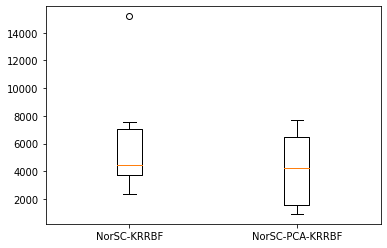

In [132]:
plt.boxplot(MAE_KR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_KR)
plt.show()

In [133]:
val = 100*100
cont = -1
for i in range(MAE_KR.shape[0]):
  for j in range(MAE_KR.shape[1]):
    cont +=1    
    if (val > MAE_KR[i,j]):
      val = MAE_KR[i,j]
      pos = cont

print(pos)
print(val)

1
919.2528729928121


In [134]:
MAE_KR

array([[ 3071.82644999,   919.25287299],
       [ 7505.38743153,  7686.96649725],
       [ 4002.23521397,  1477.11872982],
       [ 2348.89913512,  1680.99349522],
       [ 3649.52230809,  1135.32305758],
       [ 5706.91478148,  7446.48280718],
       [ 4890.75248095,  3449.16832699],
       [15191.89185574,  6584.18248353],
       [ 7547.2509195 ,  4990.31372072],
       [ 3959.64986105,  6169.02542084]])

In [135]:
B_Model[pos]

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.01,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [136]:
print(B_Hiperpara[pos])
B_Hiperpara

{'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}


[{'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5},
 {'reg__alpha': 0.01, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components'

In [137]:
steps =  [('scaler', StandardScaler()),
          ('rep', PCA(n_components=0.5)),                         
          ('reg', KernelRidge(alpha=0.001, kernel='rbf', gamma=0.01))]

Mod_SC_PCA_KRrbf = Pipeline(steps = steps)
Mod_SC_PCA_KRrbf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.01,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [138]:
Xn = X[-1]
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC__PCA_KRrbf = Mod_SC_PCA_KRrbf.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC__PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[4356 4561 4881 5142 5379]]
Predicción contagios para 2020-04-30 usando un modelo KernelRidge_rbf: [[5990.68510663]]
